In [ ]:
# Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import random
import sklearn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Remove printing error
pd.options.mode.chained_assignment = None

In [2]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()

random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

eicu_data = pd.read_csv('eicu_data.csv')

In [3]:
preprocessing_data = preprocessing_data.iloc[:,:6]
hold_out_data = hold_out_data.iloc[:,:6]
eicu_data = eicu_data.iloc[:,:6]

# mimic

In [4]:
# Create list
hold_out_data_list = hold_out_data.stay_id.unique().tolist()

In [5]:
# Load filtered chartevents data
iter_csv = pd.read_csv(r"mimic-iv-2.0/icu/chartevents.csv", iterator=True, chunksize=10000000)
chartevents = pd.concat([chunk[chunk['stay_id'].isin(hold_out_data_list)] for chunk in iter_csv])

In [6]:
# Find relevant codes
d_items = pd.read_csv(r"mimic-iv-2.0/icu/d_items.csv")

pattern = 'Heart.Rate|temperature|febrile|WBC|C.Reactive.Protein|CRP|blood.pressure|respiratory.rate|Conscious|Richmond-RAS Scale|GCS -' # Added Richmond-RAS Scale and GCS -

filtered_d_items = d_items[d_items['label'].str.contains(pattern, case=False, na=False)]

filtered_d_items_list = filtered_d_items['itemid'].unique().tolist()

# Filter for relevant codes
filtered_chartevents = chartevents[chartevents['itemid'].isin(filtered_d_items_list)]

filtered_chartevents = filtered_chartevents.merge(filtered_d_items[['itemid', 'label']], how='left', on=['itemid'])

# Convert Farenhight to celcius 
filtered_chartevents.loc[filtered_chartevents['label'].str.contains('Temperature Fahrenheit'), 'valuenum'] = (filtered_chartevents.loc[filtered_chartevents['label'].str.contains('Temperature Fahrenheit'), 'valuenum']-32)*(5/9)

# Drop PAR-Consciousness, Temperature Site, Changes in Temperature, Blood Pressure Alarm
drop_pattern = 'PAR-Consciousness|Temperature Site|Changes in Temperature|Blood Pressure Alarm'
filtered_chartevents2 = filtered_chartevents[~filtered_chartevents['label'].str.contains(drop_pattern, case=False, na=False)]

string_list = [
 'Heart rate Alarm - High',
 'Heart Rate Alarm - Low',
 'Heart Rate',
 'Respiratory Rate .spontaneous',
 'Respiratory Rate .Set',
 'Respiratory Rate',
 'Skin Temperature',
 'Temperature',
 'Blood Pressure systolic',
 'Blood Pressure diastolic',
 'Blood Pressure mean',
 'WBC',
 'Level of Consciousness',
 'CRP',
 'Febrile last 24 hours',
 'GCS - Eye Opening',
 'GCS - Verbal Response',
 'GCS - Motor Response',
 'Richmond-RAS Scale']

pd.options.mode.chained_assignment = None

x = 0
for string in string_list:
    x += 1
    sub_df = filtered_chartevents2[filtered_chartevents2['label'].str.contains(string, case=False, na=False)]
    sub_df['final_label'] = string.lower() # use filter string as final_label 
    if x == 1:
        filtered_chartevents3 = sub_df
    else:
        filtered_chartevents3 = pd.concat([filtered_chartevents3, sub_df])

# Need to drop rows labeled skin temp but actually skin temperature (duplicates)
filtered_chartevents3 = filtered_chartevents3.loc[~((filtered_chartevents3['final_label'] == 'temperature') & (filtered_chartevents3['valuenum'].isna())),:]

# O2 + CO2
d_items_list = [220235, 220277, 223835]
o2_chartevents = chartevents[chartevents['itemid'].isin(d_items_list)]
o2_chartevents = o2_chartevents.merge(d_items[['itemid', 'label']], how='left', on=['itemid'])
o2_chartevents['final_label'] = o2_chartevents['label'].str.lower()
filtered_chartevents4 = pd.concat([filtered_chartevents3, o2_chartevents], axis=0)
# Select relevant labels 
final_label_list = ['heart rate', 'respiratory rate', 'blood pressure mean', 'blood pressure systolic', 'blood pressure diastolic', 'temperature', 'wbc', 'o2 saturation pulseoxymetry', 'inspired o2 fraction', 'arterial co2 pressure']
selected_catch22 = filtered_chartevents4[filtered_chartevents4['final_label'].isin(final_label_list)]

In [10]:
selected_catch22.final_label.value_counts()

heart rate                     413115
respiratory rate               404649
blood pressure mean            345661
blood pressure systolic        345425
blood pressure diastolic       345358
o2 saturation pulseoxymetry    341325
temperature                    110461
inspired o2 fraction            39884
wbc                             21647
arterial co2 pressure           18801
Name: final_label, dtype: int64

In [127]:
selected_catch22

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,final_label,date,hour
0,10002155,23822395,33685454,2129-08-04 13:45:00,2129-08-04 14:15:00,220045,68,68.0,bpm,0.0,Heart Rate,heart rate,2129-08-04,13
2,10002155,23822395,33685454,2129-08-04 13:45:00,2129-08-04 14:16:00,220046,120,120.0,bpm,0.0,Heart rate Alarm - High,heart rate,2129-08-04,13
3,10002155,23822395,33685454,2129-08-04 13:45:00,2129-08-04 14:16:00,220047,50,50.0,bpm,0.0,Heart Rate Alarm - Low,heart rate,2129-08-04,13
11,10002155,23822395,33685454,2129-08-04 14:00:00,2129-08-04 14:18:00,220045,83,83.0,bpm,0.0,Heart Rate,heart rate,2129-08-04,14
18,10002155,23822395,33685454,2129-08-04 14:15:00,2129-08-04 14:15:00,220045,71,71.0,bpm,0.0,Heart Rate,heart rate,2129-08-04,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400005,19995091,27602139,32457489,2172-08-25 15:00:00,2172-08-25 15:07:00,220277,99,99.0,%,0.0,O2 saturation pulseoxymetry,o2 saturation pulseoxymetry,2172-08-25,15
400006,19995091,27602139,32457489,2172-08-25 16:03:00,2172-08-25 16:34:00,220277,97,97.0,%,0.0,O2 saturation pulseoxymetry,o2 saturation pulseoxymetry,2172-08-25,16
400007,19995091,27602139,32457489,2172-08-25 17:00:00,2172-08-25 17:06:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,o2 saturation pulseoxymetry,2172-08-25,17
400008,19995091,27602139,32457489,2172-08-25 18:00:00,2172-08-25 19:13:00,220277,99,99.0,%,0.0,O2 saturation pulseoxymetry,o2 saturation pulseoxymetry,2172-08-25,18


Min Max Temp

In [7]:
# Filter
hold_out_data2 = selected_catch22[(selected_catch22['final_label'] == 'temperature')]

In [11]:
# Convert to str or does not work
hold_out_data.date = hold_out_data.date.astype(str)
#hold_out_data2.date = hold_out_data2.date.astype(str)

In [12]:
# Merge
hold_out_data2 = pd.merge(hold_out_data, hold_out_data2[['stay_id', 'charttime', 'valuenum']])

In [13]:
# Datetime
import datetime
hold_out_data2['charttime'] =  pd.to_datetime(hold_out_data2['charttime']).dt.date + datetime.timedelta(days=1)

In [14]:
# Convert to str
hold_out_data2['charttime'] = hold_out_data2['charttime'].astype(str)
hold_out_data2['date'] = hold_out_data2['date'].astype(str)

In [15]:
# Filter
hold_out_data3 = hold_out_data2.loc[hold_out_data2['date'] == hold_out_data2['charttime']]

In [16]:
hold_out_data3.po_flag.value_counts()

0    61996
1    17943
Name: po_flag, dtype: int64

In [134]:
hold_out_data3.columns

Index(['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag',
       'iv_treatment_length', 'charttime', 'valuenum'],
      dtype='object')

In [17]:
def summary_function(df):
    return df['valuenum'].agg(['min','max'])

In [18]:
# Get max and min
hold_out_data4 = hold_out_data3.groupby(['stay_id', 'date'], as_index=False).apply(summary_function)

In [19]:
# Merge
hold_out_data5 = pd.merge(hold_out_data3[['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length']], hold_out_data4)
hold_out_data5.drop_duplicates(inplace=True)

In [138]:
hold_out_data5

,stay_id,date,iv_flag,first_po_flag,po_flag,iv_treatment_length,min,max
0,31658148,2154-01-12,1.0,1.0,0,1,35.000000,37.600000
18,31658148,2154-01-13,1.0,1.0,0,2,36.888889,37.600000
31,33816676,2117-08-21,1.0,1.0,0,0,37.055556,37.666667
36,33816676,2117-08-22,1.0,1.0,0,1,36.944444,39.111111
44,32889989,2126-06-04,1.0,1.0,0,1,35.600000,36.800000
...,...,...,...,...,...,...,...,...
79912,30772812,2130-06-08,1.0,1.0,0,1,35.555556,37.500000
79922,37914144,2136-05-23,1.0,1.0,0,1,36.555556,36.888889
79925,37246494,2127-07-18,1.0,1.0,0,1,36.888889,38.333333
79927,37246494,2127-07-19,1.0,1.0,0,2,36.555556,37.944444


Pivot

In [20]:
# Create date column 
selected_catch22['date'] =  pd.to_datetime(selected_catch22['charttime']).dt.date
# Create hour column
selected_catch22['hour'] =  pd.to_datetime(selected_catch22['charttime']).dt.hour

In [21]:
# Pivot
catch22_pivoted2 = pd.pivot_table(selected_catch22, index=['subject_id', 'hadm_id', 'stay_id', 'date'], columns=['final_label'], values=['valuenum']) # Removed hour from pivot as dont need as not doiing c22
catch22_pivoted2.columns = catch22_pivoted2.columns.droplevel()
catch22_pivoted2 = catch22_pivoted2.reset_index()
catch22_pivoted2.columns = catch22_pivoted2.columns.str.replace(' ','_') 
catch22_pivoted2

final_label,subject_id,hadm_id,stay_id,date,arterial_co2_pressure,blood_pressure_diastolic,blood_pressure_mean,blood_pressure_systolic,heart_rate,inspired_o2_fraction,o2_saturation_pulseoxymetry,respiratory_rate,temperature,wbc
0,10002155,23822395,33685454,2129-08-04,NaN,60.250000,77.250000,117.333333,77.125000,NaN,92.250000,15.583333,36.166667,5.5
1,10002155,23822395,33685454,2129-08-05,48.0,51.782609,64.000000,102.652174,78.906250,95.000000,92.375000,16.782609,36.472222,6.5
2,10002155,23822395,33685454,2129-08-06,NaN,50.304348,66.125000,108.391304,82.115385,75.714286,92.538462,17.333333,36.657407,5.3
3,10002155,23822395,33685454,2129-08-07,NaN,57.083333,71.125000,117.208333,82.620690,95.000000,93.960000,15.840000,36.129630,5.4
4,10002155,23822395,33685454,2129-08-08,NaN,53.956522,66.833333,108.291667,82.172414,95.000000,93.500000,15.478261,35.944444,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17237,19992885,20352341,35180845,2152-07-22,31.0,57.521739,82.173913,136.391304,78.344828,38.333333,99.086957,12.789474,37.055556,12.5
17238,19992885,20352341,35180845,2152-07-23,33.0,62.434783,90.217391,149.086957,74.964286,35.000000,98.461538,14.657895,37.296296,15.7
17239,19992885,20352341,35180845,2152-07-24,NaN,67.838710,97.161290,151.000000,72.303030,35.000000,91.687500,19.195122,36.972222,17.1
17240,19995091,27602139,32457489,2172-08-24,37.4,65.937500,80.125000,108.062500,71.000000,48.000000,99.133333,14.600000,36.361111,15.0


In [35]:
print('Average % of missing values (columns):', (catch22_pivoted2.isnull().sum(axis=0)/len(catch22_pivoted2)).mean())
print('Average % of missing values (row):', (catch22_pivoted2.isnull().sum(axis=1)/len(catch22_pivoted2.columns)).mean())

Average % of missing values (columns): 0.37030526007427544
Average % of missing values (row): 0.37030526007363374


Rest of features

In [22]:
# Convert to datetime 
filtered_chartevents3['charttime'] =  pd.to_datetime(filtered_chartevents3['charttime']).dt.date
# Rename
filtered_chartevents3.rename(columns={'charttime':'date'}, inplace=True)

In [23]:
# level of consciousness
consciousness = filtered_chartevents3[filtered_chartevents3['final_label'] == 'level of consciousness']
#consciousness
consciousness.value = consciousness.value.map({'Alert':0, 'Arouse to Voice':1, 'Lethargic':1, 'Arouse to Pain':1, 'Unresponsive':1, 'Arouse to Stimulation':1, 'Awake/Unresponsive':1})
#consciousness = consciousness.drop_duplicates(subset=(['subject_id', 'hadm_id', 'date', 'final_label', 'value']))
#consciousness

# Pivot
consciousness_pivoted = pd.pivot_table(consciousness, index=['subject_id', 'hadm_id', 'stay_id', 'date'], columns=['final_label'], values=['value'])
# Drop First Level and add level label as prefix
consciousness_pivoted.columns = consciousness_pivoted.columns.droplevel()
consciousness_pivoted = consciousness_pivoted.reset_index()
consciousness_pivoted.columns = consciousness_pivoted.columns.str.replace(' ','_') 

# Note left so that you can have a range from 0 to 1 for this (mean of day)
consciousness_pivoted.level_of_consciousness.value_counts()

0.000000    1963
1.000000     930
0.500000     224
0.333333     198
0.166667     165
0.666667     155
0.833333     101
0.250000     101
0.200000     100
0.400000      62
0.750000      54
0.600000      53
0.800000      42
0.142857      21
0.285714      21
0.571429      21
0.428571      18
0.857143      14
0.714286      11
0.625000       9
0.875000       9
0.125000       5
0.222222       5
0.777778       4
0.375000       4
0.545455       3
0.444444       3
0.454545       2
0.888889       2
0.692308       2
0.916667       2
0.900000       2
0.363636       2
0.272727       2
0.416667       2
0.818182       2
0.923077       2
0.100000       2
0.230769       1
0.700000       1
0.809524       1
0.153846       1
0.909091       1
0.526316       1
0.130435       1
0.882353       1
0.352941       1
0.933333       1
0.050000       1
0.083333       1
0.647059       1
0.181818       1
0.538462       1
0.300000       1
0.954545       1
0.727273       1
0.928571       1
0.944444       1
0.357143      

In [24]:
# GCS and Richmond
consciousness = filtered_chartevents3[(filtered_chartevents3['final_label'].str.contains('gcs'))|(filtered_chartevents3['final_label'].str.contains('richmond'))]
# Pivot
consciousness_pivoted2 = pd.pivot_table(consciousness, index=['subject_id', 'hadm_id', 'stay_id', 'date'], columns=['final_label'], values=['valuenum'])
# Drop First Level and add level label as prefix
consciousness_pivoted2.columns = consciousness_pivoted2.columns.droplevel()
consciousness_pivoted2 = consciousness_pivoted2.reset_index()
consciousness_pivoted2.columns = consciousness_pivoted2.columns.str.replace(' ','_') 
consciousness_pivoted2.rename(columns={'gcs_-_eye_opening': 'gcs_eye_opening', 'gcs_-_motor_response':'gcs_motor_response',	'gcs_-_verbal_response':'gcs_verbal_response',	'richmond-ras_scale':'richmond_ras_scale'}, inplace=True)

In [56]:
consciousness_pivoted2

final_label,subject_id,hadm_id,stay_id,date,gcs_eye_opening,gcs_motor_response,gcs_verbal_response,richmond_ras_scale
0,10002155,23822395,33685454,2129-08-04,4.000000,6.000000,5.0,NaN
1,10002155,23822395,33685454,2129-08-05,4.000000,6.000000,5.0,NaN
2,10002155,23822395,33685454,2129-08-06,4.000000,6.000000,5.0,NaN
3,10002155,23822395,33685454,2129-08-07,4.000000,6.000000,5.0,NaN
4,10002155,23822395,33685454,2129-08-08,4.000000,6.000000,5.0,NaN
...,...,...,...,...,...,...,...,...
16842,19992885,20352341,35180845,2152-07-22,2.133333,5.533333,1.0,-1.250
16843,19992885,20352341,35180845,2152-07-23,1.833333,4.333333,1.0,-1.375
16844,19992885,20352341,35180845,2152-07-24,2.000000,4.000000,1.0,-1.000
16845,19995091,27602139,32457489,2172-08-24,2.000000,3.500000,3.0,-0.250


NEWS

In [25]:
# Merge pivots
chartevents_pivoted = pd.merge(catch22_pivoted2, consciousness_pivoted, how='outer') # on=['stay_id', 'date']
chartevents_pivoted = pd.merge(chartevents_pivoted, consciousness_pivoted2, how='outer')

In [89]:
hold_out_data.stay_id.nunique()
len(set(chartevents_pivoted.stay_id.unique()) & set(hold_out_data.stay_id.unique()))

4347

4347

In [26]:
# Convert to str or does not work
hold_out_data.date = hold_out_data.date.astype(str)
chartevents_pivoted.date = chartevents_pivoted.date.astype(str)

In [27]:
chartevents_pivoted = pd.merge(hold_out_data, chartevents_pivoted.drop(columns=['subject_id', 'hadm_id']), how='left')

In [119]:
chartevents_pivoted

,stay_id,date,iv_flag,first_po_flag,po_flag,iv_treatment_length,arterial_co2_pressure,blood_pressure_diastolic,blood_pressure_mean,blood_pressure_systolic,...,inspired_o2_fraction,o2_saturation_pulseoxymetry,respiratory_rate,temperature,wbc,level_of_consciousness,gcs_eye_opening,gcs_motor_response,gcs_verbal_response,richmond_ras_scale
0,31658148,2154-01-11,1.0,1.0,0,0,37.0,56.300000,78.900000,117.300000,...,63.333333,99.100000,11.080000,36.488889,7.90,NaN,2.666667,4.333333,2.333333,-1.000000
1,31658148,2154-01-12,1.0,1.0,0,1,NaN,54.840000,75.600000,121.040000,...,NaN,96.541667,15.000000,37.400855,13.30,NaN,4.000000,6.000000,5.000000,-0.090909
2,31658148,2154-01-13,1.0,1.0,0,2,NaN,72.909091,81.363636,107.272727,...,NaN,95.363636,20.272727,36.916667,15.10,NaN,4.000000,6.000000,5.000000,0.000000
3,33816676,2117-08-21,1.0,1.0,0,0,39.0,75.000000,87.806452,115.225806,...,NaN,97.000000,26.580645,37.694444,11.00,NaN,4.000000,6.000000,5.000000,0.000000
4,33816676,2117-08-22,1.0,1.0,0,1,NaN,69.142857,81.095238,106.619048,...,NaN,98.333333,22.285714,37.333333,11.45,NaN,4.000000,6.000000,5.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14298,37914144,2136-05-23,1.0,1.0,0,1,NaN,76.235294,93.647059,125.058824,...,NaN,94.944444,16.000000,36.677778,13.30,NaN,4.000000,6.000000,5.000000,0.000000
14299,37246494,2127-07-17,1.0,1.0,0,0,NaN,28.250000,39.750000,77.750000,...,NaN,94.600000,25.400000,37.611111,15.60,NaN,4.000000,6.000000,5.000000,0.000000
14300,37246494,2127-07-18,1.0,1.0,0,1,NaN,34.500000,46.700000,88.600000,...,NaN,93.095238,24.863636,37.031746,13.85,NaN,4.000000,6.000000,5.000000,0.000000
14301,37246494,2127-07-19,1.0,1.0,0,2,NaN,45.304348,56.391304,93.739130,...,NaN,95.956522,22.958333,36.788889,10.80,NaN,4.000000,6.000000,5.000000,0.000000


In [28]:
def NEWS2_function(respiratory_rate, arterial_co2_pressure, o2_saturation_pulseoxymetry, inspired_o2_fraction, temperature, blood_pressure_systolic, heart_rate, level_of_consciousness, gcs_eye_opening, gcs_motor_response, gcs_verbal_response, richmond_ras_scale):
    score = 0

    if respiratory_rate <= 8:
        score += 3
    elif respiratory_rate < 12:
        score += 1
    elif respiratory_rate >= 25:
        score += 3
    elif respiratory_rate > 20:
        score += 2
    
    if arterial_co2_pressure >= 50:
        if o2_saturation_pulseoxymetry <= 83:
            score += 3
        elif o2_saturation_pulseoxymetry < 86:
            score += 2
        elif o2_saturation_pulseoxymetry < 88:
            score += 1
        elif inspired_o2_fraction > 21:
            if o2_saturation_pulseoxymetry >= 97:
                score += 3
            elif o2_saturation_pulseoxymetry > 95:
                score += 2
            elif o2_saturation_pulseoxymetry > 93:
                score += 1
    else:
        if o2_saturation_pulseoxymetry <= 91:
            score += 3
        elif o2_saturation_pulseoxymetry < 94:
            score += 2
        elif o2_saturation_pulseoxymetry < 96:
            score += 1

    if inspired_o2_fraction > 21:
        score += 2
    
    if temperature <= 35:
        score += 3
    elif temperature <= 36:
        score += 1
    elif temperature > 39:
        score += 2
    elif temperature > 38:
        score += 1
    
    if blood_pressure_systolic <= 90:
        score += 3
    elif blood_pressure_systolic <= 100:
        score += 2
    elif blood_pressure_systolic <= 100:
        score += 1
    elif blood_pressure_systolic >= 220:
        score += 3
    
    if heart_rate <= 40:
        score += 3
    elif heart_rate <= 50:
        score += 1
    elif heart_rate >= 131:
        score += 3
    elif heart_rate >= 111:
        score += 2
    elif heart_rate >= 91:
        score += 1
    
    if level_of_consciousness > 0:
        score += 3
    elif gcs_eye_opening < 4:
        score += 3
    elif gcs_verbal_response < 5:
        score += 3
    elif gcs_motor_response < 6:
        score += 3
    elif richmond_ras_scale > 0:
        score += 3
    elif richmond_ras_scale < 0:
        score += 3

    return score

In [29]:
# Calculate NEWS 2 score for each
chartevents_pivoted['news2'] = chartevents_pivoted.apply(lambda x: NEWS2_function(x['respiratory_rate'], x['arterial_co2_pressure'], x['o2_saturation_pulseoxymetry'], x['inspired_o2_fraction'], x['temperature'], x['blood_pressure_systolic'], x['heart_rate'], x['level_of_consciousness'], x['gcs_eye_opening'], x['gcs_motor_response'], x['gcs_verbal_response'], x['richmond_ras_scale']), axis=1)

In [123]:
chartevents_pivoted

,stay_id,date,iv_flag,first_po_flag,po_flag,iv_treatment_length,arterial_co2_pressure,blood_pressure_diastolic,blood_pressure_mean,blood_pressure_systolic,...,o2_saturation_pulseoxymetry,respiratory_rate,temperature,wbc,level_of_consciousness,gcs_eye_opening,gcs_motor_response,gcs_verbal_response,richmond_ras_scale,news2
0,31658148,2154-01-11,1.0,1.0,0,0,37.0,56.300000,78.900000,117.300000,...,99.100000,11.080000,36.488889,7.90,NaN,2.666667,4.333333,2.333333,-1.000000,6
1,31658148,2154-01-12,1.0,1.0,0,1,NaN,54.840000,75.600000,121.040000,...,96.541667,15.000000,37.400855,13.30,NaN,4.000000,6.000000,5.000000,-0.090909,3
2,31658148,2154-01-13,1.0,1.0,0,2,NaN,72.909091,81.363636,107.272727,...,95.363636,20.272727,36.916667,15.10,NaN,4.000000,6.000000,5.000000,0.000000,4
3,33816676,2117-08-21,1.0,1.0,0,0,39.0,75.000000,87.806452,115.225806,...,97.000000,26.580645,37.694444,11.00,NaN,4.000000,6.000000,5.000000,0.000000,4
4,33816676,2117-08-22,1.0,1.0,0,1,NaN,69.142857,81.095238,106.619048,...,98.333333,22.285714,37.333333,11.45,NaN,4.000000,6.000000,5.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14298,37914144,2136-05-23,1.0,1.0,0,1,NaN,76.235294,93.647059,125.058824,...,94.944444,16.000000,36.677778,13.30,NaN,4.000000,6.000000,5.000000,0.000000,1
14299,37246494,2127-07-17,1.0,1.0,0,0,NaN,28.250000,39.750000,77.750000,...,94.600000,25.400000,37.611111,15.60,NaN,4.000000,6.000000,5.000000,0.000000,8
14300,37246494,2127-07-18,1.0,1.0,0,1,NaN,34.500000,46.700000,88.600000,...,93.095238,24.863636,37.031746,13.85,NaN,4.000000,6.000000,5.000000,0.000000,8
14301,37246494,2127-07-19,1.0,1.0,0,2,NaN,45.304348,56.391304,93.739130,...,95.956522,22.958333,36.788889,10.80,NaN,4.000000,6.000000,5.000000,0.000000,6


Predictions

In [50]:
# Merge
chartevents_pivoted2_2 = pd.merge(chartevents_pivoted, hold_out_data5, how='outer')

In [51]:
# Get baseline predictions 
cumcount = []
count = 1
pos = -1
flag = 0

for x in range(len(chartevents_pivoted2_2)):
    pos += 1
    if pos == 0:
        cumcount.append(np.nan)
    elif chartevents_pivoted2_2.iloc[x]['stay_id'] == chartevents_pivoted2_2.iloc[x-1]['stay_id']:
        if flag == 1:
            cumcount.append(1) # Changed to aways predict switch after initial switch prediction for each stay
        else:
            if np.isnan(chartevents_pivoted2_2.iloc[x]['max']):# == chartevents_pivoted2.iloc[x]['max']: # Check if nan
                cumcount.append(np.nan)
            elif chartevents_pivoted2_2.iloc[x]['news2'] < chartevents_pivoted2_2.iloc[x-1]['news2']:
                if chartevents_pivoted2_2.iloc[x]['max'] > 38:
                    cumcount.append(0)
                elif chartevents_pivoted2_2.iloc[x]['min'] < 36:
                    cumcount.append(0)
                else:
                    cumcount.append(1)
                    flag = 1
            else:
                cumcount.append(0)
    elif np.isnan(chartevents_pivoted2_2.iloc[x]['max']):# == chartevents_pivoted2.iloc[x]['max']: # Check if nan
        cumcount.append(np.nan)
        flag = 0
    elif chartevents_pivoted2_2.iloc[x]['news2'] < chartevents_pivoted2_2.iloc[x-1]['news2']:
        if chartevents_pivoted2_2.iloc[x]['max'] > 38:
            cumcount.append(0)
            flag = 0
        elif chartevents_pivoted2_2.iloc[x]['min'] < 36:
            cumcount.append(0)
            flag = 0
        else:
            cumcount.append(1)
            flag = 1
    else:
        cumcount.append(0)
        flag = 0

print(len(cumcount))
chartevents_pivoted2_2['predictions'] = cumcount

14303


In [52]:
# Get strictbaseline predictions 
cumcount = []
count = 1
pos = -1
flag = 0

for x in range(len(chartevents_pivoted2_2)):
    pos += 1
    if pos == 0:
        cumcount.append(np.nan)
    elif chartevents_pivoted2_2.iloc[x]['stay_id'] == chartevents_pivoted2_2.iloc[x-1]['stay_id']:
        if flag == 1:
            cumcount.append(1) # Changed to aways predict switch after initial switch prediction for each stay
        else:
            if np.isnan(chartevents_pivoted2_2.iloc[x]['max']):# == chartevents_pivoted2.iloc[x]['max']: # Check if nan
                cumcount.append(np.nan)
            elif chartevents_pivoted2_2.iloc[x]['news2'] < chartevents_pivoted2_2.iloc[x-1]['news2']:
                if chartevents_pivoted2_2.iloc[x]['news2'] < 7: # Add in threshold of NEWS less than 7
                    if chartevents_pivoted2_2.iloc[x]['max'] > 38:
                        cumcount.append(0)
                    elif chartevents_pivoted2_2.iloc[x]['min'] < 36:
                        cumcount.append(0)
                    else:
                        cumcount.append(1)
                        flag = 1
                else:
                    cumcount.append(0)
            else:
                cumcount.append(0)
    elif np.isnan(chartevents_pivoted2_2.iloc[x]['max']):# == chartevents_pivoted2.iloc[x]['max']: # Check if nan
        cumcount.append(np.nan)
        flag = 0
    elif chartevents_pivoted2_2.iloc[x]['news2'] < chartevents_pivoted2_2.iloc[x-1]['news2']:
        if chartevents_pivoted2_2.iloc[x]['news2'] < 7: # Add in threshold of NEWS less than 7
            if chartevents_pivoted2_2.iloc[x]['max'] > 38:
                cumcount.append(0)
                flag = 0
            elif chartevents_pivoted2_2.iloc[x]['min'] < 36:
                cumcount.append(0)
                flag = 0
            else:
                cumcount.append(1)
                flag = 1
        else:
            cumcount.append(0)
            flag = 0
    else:
        cumcount.append(0)
        flag = 0

print(len(cumcount))
chartevents_pivoted2_2['strict_predictions'] = cumcount

14303


In [180]:
chartevents_pivoted2_2.predictions.value_counts()
chartevents_pivoted2_2.strict_predictions.value_counts()

0.0    5480
1.0    5459
Name: predictions, dtype: int64

0.0    6034
1.0    4903
Name: strict_predictions, dtype: int64

In [53]:
# Get prediction df
prediction_df2 = chartevents_pivoted2_2[['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length', 'predictions', 'strict_predictions']]
prediction_df2 = prediction_df2[prediction_df2['predictions'].notna()]
prediction_df2 = prediction_df2[prediction_df2['strict_predictions'].notna()]

In [186]:
prediction_df2

,stay_id,date,iv_flag,first_po_flag,po_flag,iv_treatment_length,predictions,strict_predictions
1,31658148,2154-01-12,1.0,1.0,0,1,0.0,0.0
2,31658148,2154-01-13,1.0,1.0,0,2,0.0,0.0
3,33816676,2117-08-21,1.0,1.0,0,0,0.0,0.0
4,33816676,2117-08-22,1.0,1.0,0,1,0.0,0.0
6,32889989,2126-06-04,1.0,1.0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...
14296,30772812,2130-06-08,1.0,1.0,0,1,0.0,0.0
14298,37914144,2136-05-23,1.0,1.0,0,1,1.0,1.0
14300,37246494,2127-07-18,1.0,1.0,0,1,0.0,0.0
14301,37246494,2127-07-19,1.0,1.0,0,2,1.0,1.0


Results

In [187]:
get_results(prediction_df2.po_flag, prediction_df2.predictions)

AUROC: 0.6604952552141343
Accuracy: 0.6093992868245406
Recall: 0.7505285412262156
Precision: 0.3252702950339014
F1: 0.45384812068524677
AUPRC: 0.2980699632507904
CM: [[4890 3682]
 [ 590 1775]]
TPR: 0.7505285412262156
FPR: 0.4295380307979468


In [188]:
get_results(prediction_df2.po_flag, prediction_df2.strict_predictions)

AUROC: 0.6596310175516136
Accuracy: 0.6375605741976776
Recall: 0.6985200845665962
Precision: 0.3369365694472772
F1: 0.45459548706659325
AUPRC: 0.3005485125976789
CM: [[5321 3251]
 [ 713 1652]]
TPR: 0.6985200845665962
FPR: 0.3792580494633691


In [ ]:
treatment_length_df = pd.DataFrame()

for i in prediction_df2.iv_treatment_length.unique():
    print(i)
    temp_test_data = prediction_df2[prediction_df2['iv_treatment_length'] == i]
    test_labels = temp_test_data.po_flag
    lower_bound_test_predictions = temp_test_data.predictions
    upper_bound_test_predictions = temp_test_data.strict_predictions

    print(np.unique(test_labels, return_counts=True))
    print(np.unique(lower_bound_test_predictions, return_counts=True))

    label_values, label_counts = np.unique(test_labels, return_counts=True)
    lower_bound_values, lower_bound_counts =np.unique(lower_bound_test_predictions, return_counts=True)
    upper_bound_values, upper_bound_counts =np.unique(upper_bound_test_predictions, return_counts=True)

    label_0 = 0
    label_1 = 0
    for x in range(len(label_values)):
        if label_values[x] == 0:
            label_0 = label_counts[x]
        elif label_values[x] == 1:
            label_1 = label_counts[x]
    prediction_0 = 0
    prediction_1 = 0
    for x in range(len(lower_bound_values)):
        if lower_bound_values[x] == 0:
            prediction_0 = lower_bound_counts[x]
        elif lower_bound_values[x] == 1:
            prediction_1 = lower_bound_counts[x]
    ub_prediction_0 = 0
    ub_prediction_1 = 0
    for x in range(len(upper_bound_values)):
        if upper_bound_values[x] == 0:
            ub_prediction_0 = upper_bound_counts[x]
        elif upper_bound_values[x] == 1:
            ub_prediction_1 = upper_bound_counts[x]
    
    # Lower bound
    try:
        test_auroc2 = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc2 = np.nan
    #print('Test AUROC result 2:', test_auroc2)
    test_accuracy2 = accuracy_score(test_labels, lower_bound_test_predictions)
    #assert test_accuracy == test_accuracy2
    test_balanced_accuracy = balanced_accuracy_score(test_labels, lower_bound_test_predictions)
    test_recall = recall_score(test_labels, lower_bound_test_predictions)
    test_precision = precision_score(test_labels, lower_bound_test_predictions)
    test_f1 = f1_score(test_labels, lower_bound_test_predictions)
    test_auprc = average_precision_score(test_labels, lower_bound_test_predictions)
    test_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
    if test_cm.shape == (2, 2):
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    else:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    # Upper bound
    try:
        ub_test_auroc2 = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc2 = np.nan
    #print('Test ub_AUROC result 2:', ub_test_auroc2)
    ub_test_accuracy2 = accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_balanced_accuracy = balanced_accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_recall = recall_score(test_labels, upper_bound_test_predictions)
    ub_test_precision = precision_score(test_labels, upper_bound_test_predictions)
    ub_test_f1 = f1_score(test_labels, upper_bound_test_predictions)
    ub_test_auprc = average_precision_score(test_labels, upper_bound_test_predictions)
    ub_test_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
    if ub_test_cm.shape == (2, 2):
        tn, fp, fn, tp = ub_test_cm.ravel()
        ub_test_true_positive_rate = (tp / (tp + fn))
        ub_test_false_positive_rate = (fp / (fp + tn))
    else:
        ub_test_true_positive_rate = np.nan
        ub_test_false_positive_rate = np.nan
    
    sub_df = pd.DataFrame([[i, label_0, label_1, prediction_0, prediction_1, test_auroc2, test_balanced_accuracy, test_accuracy2, test_recall, test_precision, test_f1, test_auprc, test_cm, test_true_positive_rate, test_false_positive_rate, ub_prediction_0, ub_prediction_1, ub_test_auroc2, ub_test_balanced_accuracy, ub_test_accuracy2, ub_test_recall, ub_test_precision, ub_test_f1, ub_test_auprc, ub_test_cm, ub_test_true_positive_rate, ub_test_false_positive_rate]])
    treatment_length_df = pd.concat([treatment_length_df, sub_df], axis=0, ignore_index=True)
treatment_length_df.columns = ['iv_treatment_length', 'label_0', 'label_1', 'prediction_0', 'prediction_1', 'auroc', 'balanced_accuracy', 'accuracy', 'recall', 'precision', 'f1', 'auprc', 'cm', 'tpr', 'fpr', 'ub_prediction_0', 'ub_prediction_1','ub_auroc', 'ub_balanced_accuracy', 'ub_accuracy', 'ub_recall', 'ub_precision', 'ub_f1', 'ub_auprc', 'ub_cm', 'ub_tpr', 'ub_fpr']
treatment_length_df.sort_values(by=['iv_treatment_length'], inplace=True)
# Set to string
treatment_length_df['iv_treatment_length']= treatment_length_df['iv_treatment_length'].astype(str)
# Change 999
treatment_length_df['iv_treatment_length'] = treatment_length_df['iv_treatment_length'].replace(['999'], 'PO')
# Rename
treatment_length_df.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length', 'label_0': 'Continue with IV', 'label_1': 'Switch to PO'}, inplace=True)

In [55]:
df1 = treatment_length_df[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = treatment_length_df[['Proir days cumulative IV treatment length', 'prediction_0', 'prediction_1']].set_index(['Proir days cumulative IV treatment length'])
df3 = treatment_length_df[['Proir days cumulative IV treatment length', 'ub_prediction_0', 'ub_prediction_1']].set_index(['Proir days cumulative IV treatment length'])

<AxesSubplot:title={'center':'Labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

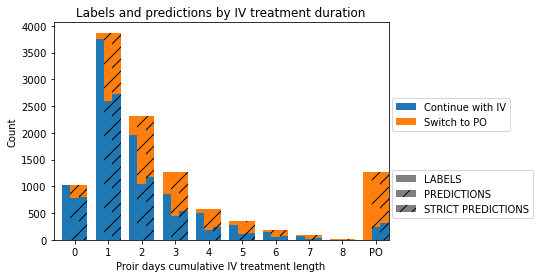

In [191]:
plot_clustered_stacked([df1, df2, df3],["LABELS", "PREDICTIONS", "STRICT PREDICTIONS"], title="Labels and predictions by IV treatment duration",  H="/")

<AxesSubplot:title={'center':'MIMIC labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

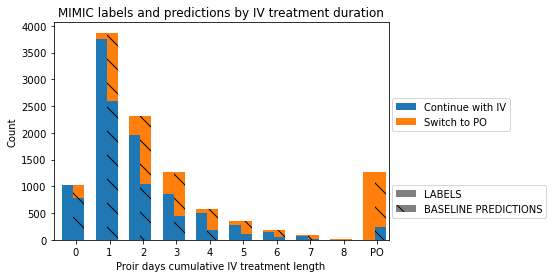

In [56]:
plot_clustered_stacked([df1, df2],["LABELS", "BASELINE PREDICTIONS"], title="MIMIC labels and predictions by IV treatment duration",  H="\\")

# eicu

In [57]:
# get list 
eicu_data_list = eicu_data.stay_id.unique().tolist()

In [58]:
iter_csv = pd.read_csv(r"eicu-collaborative-research-database-2.0/vitalPeriodic.csv", iterator=True, chunksize=10000000)
vitalperiodic = pd.concat([chunk[chunk['patientunitstayid'].isin(eicu_data_list)] for chunk in iter_csv])

iter_csv = pd.read_csv(r"eicu-collaborative-research-database-2.0/vitalAperiodic.csv", iterator=True, chunksize=10000000)
vitalaperiodic = pd.concat([chunk[chunk['patientunitstayid'].isin(eicu_data_list)] for chunk in iter_csv])

iter_csv = pd.read_csv(r"eicu-collaborative-research-database-2.0/physicalExam.csv", iterator=True, chunksize=10000000)
physicalexam = pd.concat([chunk[chunk['patientunitstayid'].isin(eicu_data_list)] for chunk in iter_csv])

iter_csv = pd.read_csv(r"eicu-collaborative-research-database-2.0/lab.csv", iterator=True, chunksize=10000000)
lab = pd.concat([chunk[chunk['patientunitstayid'].isin(eicu_data_list)] for chunk in iter_csv])

/tmp/ipykernel_17702/3531519620.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  lab = pd.concat([chunk[chunk['patientunitstayid'].isin(eicu_data_list)] for chunk in iter_csv])


In [59]:
# Get unitadmittime24
# Note unit admit date = 02 Sep 2022
iter_csv = pd.read_csv(r"eicu-collaborative-research-database-2.0/patient.csv", iterator=True, chunksize=10000000)
patients = pd.concat([chunk[chunk['patientunitstayid'].isin(eicu_data_list)] for chunk in iter_csv])

# Select relevant columns
patients = patients[['patientunitstayid', 'unitadmittime24']]
# Convert unit admit time to day (day 0)
patients['unitadmittime24'] = pd.to_datetime(patients['unitadmittime24'])
# Set start date
patients['unitadmittime24'] = patients['unitadmittime24'].apply(lambda t: t.replace(year=2022, month=9, day=2))

# Merge
vitalperiodic = pd.merge(patients, vitalperiodic, on=['patientunitstayid'])
vitalaperiodic = pd.merge(patients, vitalaperiodic, on=['patientunitstayid'])
physicalexam = pd.merge(patients, physicalexam, on=['patientunitstayid'])
lab = pd.merge(patients, lab, on=['patientunitstayid'])

# Create observationtime
vitalperiodic['observationoffset'] = pd.to_timedelta(vitalperiodic['observationoffset'], unit='min') # Convert to timedelta
vitalperiodic['observationtime'] = vitalperiodic['unitadmittime24'] + vitalperiodic['observationoffset']

vitalaperiodic['observationoffset'] = pd.to_timedelta(vitalaperiodic['observationoffset'], unit='min') # Convert to timedelta
vitalaperiodic['observationtime'] = vitalaperiodic['unitadmittime24'] + vitalaperiodic['observationoffset']

physicalexam['physicalexamoffset'] = pd.to_timedelta(physicalexam['physicalexamoffset'], unit='min') # Convert to timedelta
physicalexam['observationtime'] = physicalexam['unitadmittime24'] + physicalexam['physicalexamoffset']

lab['labresultoffset'] = pd.to_timedelta(lab['labresultoffset'], unit='min') # Convert to timedelta
lab['observationtime'] = lab['unitadmittime24'] + lab['labresultoffset']

physicalexam

In [ ]:
# Are also GCS 'Level of Consciousness' ones but not including as not included in model
# physicalexam[physicalexam.physicalexampath.str.contains('GCS', case=False)]['physicalexampath'].value_counts()

In [60]:
# Filter for GCS
physicalexam = physicalexam[physicalexam.physicalexampath.str.contains('GCS')]
score = 'Motor Score|Verbal Score|Eyes Score'
# Filter for the three scores
physicalexam = physicalexam[physicalexam.physicalexampath.str.contains(score)]
# Remame
physicalexam.loc[physicalexam['physicalexampath'].str.contains('Eyes Score'), 'physicalexampath'] = 'gcs - eye opening'
physicalexam.loc[physicalexam['physicalexampath'].str.contains('Verbal Score'), 'physicalexampath'] = 'gcs - verbal response'
physicalexam.loc[physicalexam['physicalexampath'].str.contains('Motor Score'), 'physicalexampath'] = 'gcs - motor response'
# Order
physicalexam = physicalexam.sort_values(by=['patientunitstayid', 'observationtime'])
# Create date column 
physicalexam['date'] =  pd.to_datetime(physicalexam['observationtime']).dt.date
# Create hour column
#physicalexam['hour'] =  pd.to_datetime(physicalexam['observationtime']).dt.hour # Remove hour from group by as dont need here
# Pivot
physicalexam_pivoted = pd.pivot_table(physicalexam, index=['patientunitstayid', 'date'], columns=['physicalexampath'], values=['physicalexamvalue'])
physicalexam_pivoted.columns = physicalexam_pivoted.columns.droplevel()
physicalexam_pivoted = physicalexam_pivoted.reset_index()
physicalexam_pivoted.columns = physicalexam_pivoted.columns.str.replace(' ','_') 
physicalexam_pivoted.rename(columns={'gcs_-_eye_opening': 'gcs_eye_opening', 'gcs_-_motor_response':'gcs_motor_response',	'gcs_-_verbal_response':'gcs_verbal_response'}, inplace=True)
physicalexam_pivoted

physicalexampath,patientunitstayid,date,gcs_eye_opening,gcs_motor_response,gcs_verbal_response
0,141392,2022-09-02,4.0,6.0,5.0
1,141470,2022-09-02,4.0,6.0,5.0
2,142405,2022-09-02,4.0,6.0,5.0
3,143068,2022-09-02,4.0,6.0,5.0
4,143157,2022-09-02,4.0,6.0,5.0
...,...,...,...,...,...
2515,3335807,2022-09-02,4.0,6.0,5.0
2516,3340875,2022-09-02,4.0,6.0,4.0
2517,3340875,2022-09-04,4.0,6.0,5.0
2518,3341168,2022-09-03,4.0,6.0,4.0


vitalperiodic / vitalaperiodic

In [61]:
# Select columns
vitalperiodic = vitalperiodic[['patientunitstayid', 'observationtime', 'temperature', 'sao2', 'heartrate', 'respiration', 'etco2', 'systemicsystolic', 'systemicdiastolic', 'systemicmean']]
vitalaperiodic = vitalaperiodic[['patientunitstayid', 'observationtime', 'noninvasivesystolic', 'noninvasivediastolic', 'noninvasivemean']]

# Merge
vital = pd.merge(vitalperiodic, vitalaperiodic, on=['patientunitstayid', 'observationtime'], how='outer')

# Create combined bp columns
vital['blood pressure systolic'] = vital[['systemicsystolic', 'noninvasivesystolic']].mean(axis=1)
vital['blood pressure diastolic'] = vital[['systemicdiastolic', 'noninvasivediastolic']].mean(axis=1)
vital['blood pressure mean'] = vital[['systemicmean', 'noninvasivemean']].mean(axis=1)

# Order
vital = vital.sort_values(by=['patientunitstayid', 'observationtime'])
# Create date column 
vital['date'] =  pd.to_datetime(vital['observationtime']).dt.date
# Create hour column
vital['hour'] =  pd.to_datetime(vital['observationtime']).dt.hour
# Select columns
final_vital = vital[['patientunitstayid', 'date', 'temperature', 'sao2', 'heartrate', 'respiration', 'etco2', 'blood pressure systolic', 'blood pressure diastolic', 'blood pressure mean']]
final_vital = final_vital.groupby(['patientunitstayid', 'date']).mean()
final_vital.reset_index(inplace=True)
final_vital.columns = final_vital.columns.str.replace(' ','_') 
final_vital

,patientunitstayid,date,temperature,sao2,heartrate,respiration,etco2,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_mean
0,141196,2022-09-02,NaN,96.437500,91.391304,22.739130,NaN,114.000000,65.000000,83.000000
1,141196,2022-09-03,NaN,95.449799,81.465863,24.242915,NaN,134.166667,72.500000,96.500000
2,141392,2022-09-02,NaN,99.458564,74.320442,NaN,NaN,122.370370,59.592593,82.259259
3,141470,2022-09-02,NaN,96.632479,105.132075,28.031447,NaN,101.611111,55.888889,75.055556
4,142405,2022-09-02,NaN,94.485294,82.925000,26.421053,NaN,121.787879,72.181818,91.030303
...,...,...,...,...,...,...,...,...,...,...
6606,3341168,2022-09-03,NaN,95.220280,98.846154,34.909091,NaN,114.275000,70.050000,86.250000
6607,3341168,2022-09-04,NaN,95.780220,88.835165,29.890110,NaN,121.457143,69.600000,89.857143
6608,3346897,2022-09-02,NaN,96.083333,84.722222,26.333333,NaN,101.100000,55.300000,73.400000
6609,3346897,2022-09-03,NaN,96.232639,80.093750,21.498099,0.0,100.000000,54.320000,71.853333


In [32]:
vital

,patientunitstayid,observationtime,temperature,sao2,heartrate,respiration,systemicsystolic,systemicdiastolic,systemicmean,noninvasivesystolic,noninvasivediastolic,noninvasivemean,blood pressure systolic,blood pressure diastolic,blood pressure mean,date,hour
257,141196,2022-09-02 22:05:00,NaN,97.0,90.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02,22
265,141196,2022-09-02 22:10:00,NaN,97.0,90.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02,22
267,141196,2022-09-02 22:15:00,NaN,97.0,90.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02,22
259,141196,2022-09-02 22:20:00,NaN,98.0,89.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02,22
253,141196,2022-09-02 22:25:00,NaN,98.0,89.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473674,3346897,2022-09-04 19:20:00,NaN,97.0,81.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-04,19
1473686,3346897,2022-09-04 19:25:00,NaN,98.0,80.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-04,19
1473690,3346897,2022-09-04 19:30:00,NaN,97.0,84.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-04,19
1473698,3346897,2022-09-04 19:35:00,NaN,97.0,79.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-04,19


In [33]:
eicu_data

,stay_id,date,iv_flag,first_po_flag,po_flag,iv_treatment_length
0,141196,2022-09-03,1.0,NaN,0,0
1,141392,2022-09-02,1.0,NaN,0,0
2,141470,2022-09-02,1.0,NaN,0,0
3,142405,2022-09-02,1.0,NaN,0,0
4,143068,2022-09-02,1.0,NaN,0,0
...,...,...,...,...,...,...
4942,3335807,2022-09-02,1.0,NaN,0,0
4943,3340875,2022-09-04,1.0,NaN,0,0
4944,3341168,2022-09-03,1.0,NaN,0,0
4945,3341168,2022-09-04,1.0,NaN,0,1


lab

In [62]:
# Filter for FiO2
filtered_lab = lab[lab['labname'].str.contains('FiO2', case=False)]
# Select columns
filtered_lab = filtered_lab[['patientunitstayid', 'observationtime', 'labresult']]
# Order
filtered_lab = filtered_lab.sort_values(by=['patientunitstayid', 'observationtime'])
# Create date column 
filtered_lab['date'] =  pd.to_datetime(filtered_lab['observationtime']).dt.date
# Create hour column
filtered_lab['hour'] =  pd.to_datetime(filtered_lab['observationtime']).dt.hour
# Select columns
final_filtered_lab = filtered_lab[['patientunitstayid', 'date', 'labresult']]
final_filtered_lab = final_filtered_lab.groupby(['patientunitstayid', 'date']).mean()
final_filtered_lab.reset_index(inplace=True)
final_filtered_lab.rename(columns={'labresult': 'inspired_o2_fraction'}, inplace=True)
final_filtered_lab

,patientunitstayid,date,inspired_o2_fraction
0,142405,2022-09-02,26.500000
1,142405,2022-09-03,25.000000
2,143068,2022-09-02,46.666667
3,143157,2022-09-02,44.000000
4,144427,2022-09-02,NaN
...,...,...,...
1895,3340875,2022-09-02,86.666667
1896,3340875,2022-09-03,50.000000
1897,3341168,2022-09-03,44.000000
1898,3341168,2022-09-06,36.000000


Min Max Temp

In [ ]:
# Filter
eicu_data2 = vital[['patientunitstayid', 'date', 'temperature']]
eicu_data2.rename(columns={'patientunitstayid':'stay_id', 'date':'date2'}, inplace=True)
# Merge
eicu_data2 = pd.merge(eicu_data, eicu_data2[['stay_id', 'date2', 'temperature']])
# Datetime
import datetime
eicu_data2['date2'] =  pd.to_datetime(eicu_data2['date2']).dt.date + datetime.timedelta(days=1)
# Convert to str
eicu_data2['date2'] = eicu_data2['date2'].astype(str)
eicu_data2['date'] = eicu_data2['date'].astype(str)
# Filter
eicu_data3 = eicu_data2.loc[eicu_data2['date'] == eicu_data2['date2']]
def summary_function(df):
    return df['temperature'].agg(['min','max'])
# Get max and min
eicu_data4 = eicu_data3.groupby(['stay_id', 'date'], as_index=False).apply(summary_function)
# Merge
eicu_data5 = pd.merge(eicu_data3[['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length']], eicu_data4)
eicu_data5.drop_duplicates(inplace=True)

In [73]:
eicu_data5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3716 entries, 0 to 957828
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stay_id              3716 non-null   int64  
 1   date                 3716 non-null   object 
 2   iv_flag              2914 non-null   float64
 3   first_po_flag        1673 non-null   float64
 4   po_flag              3716 non-null   int64  
 5   iv_treatment_length  3716 non-null   int64  
 6   min                  289 non-null    float64
 7   max                  289 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 261.3+ KB


In [35]:
eicu_data5

,stay_id,date,iv_flag,first_po_flag,po_flag,iv_treatment_length,min,max,predictions
0,141196,2022-09-03,1.0,NaN,0,0,NaN,NaN,1
24,143068,2022-09-03,NaN,1.0,1,1,NaN,NaN,1
232,143068,2022-09-04,NaN,1.0,1,999,NaN,NaN,1
523,143157,2022-09-03,1.0,NaN,0,1,NaN,NaN,1
666,143157,2022-09-04,1.0,NaN,0,2,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...
956609,3247070,2022-09-05,NaN,1.0,1,3,NaN,NaN,1
956909,3247070,2022-09-06,NaN,1.0,1,999,NaN,NaN,1
957197,3247135,2022-09-05,NaN,1.0,1,999,NaN,NaN,1
957492,3340875,2022-09-04,1.0,NaN,0,0,NaN,NaN,1


NEWS

In [66]:
# Convert to str or does not work
eicu_data.date = eicu_data.date.astype(str)
final_vital.date = final_vital.date.astype(str)
final_filtered_lab.date = final_filtered_lab.date.astype(str)
physicalexam_pivoted.date = physicalexam_pivoted.date.astype(str)
# Rename
final_vital.rename(columns={'patientunitstayid': 'stay_id'}, inplace=True)
final_filtered_lab.rename(columns={'patientunitstayid': 'stay_id'}, inplace=True)
physicalexam_pivoted.rename(columns={'patientunitstayid': 'stay_id'}, inplace=True)

In [67]:
# Merge pivots
eicu_pivoted = pd.merge(eicu_data, final_vital, how='left')
eicu_pivoted = pd.merge(eicu_pivoted, final_filtered_lab, how='left')
eicu_pivoted = pd.merge(eicu_pivoted, physicalexam_pivoted, how='left')

In [65]:
eicu_pivoted

,stay_id,date,iv_flag,first_po_flag,po_flag,iv_treatment_length,temperature,sao2,heartrate,respiration,etco2,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_mean,inspired_o2_fraction,gcs_eye_opening,gcs_motor_response,gcs_verbal_response
0,141196,2022-09-03,1.0,NaN,0,0,NaN,95.449799,81.465863,24.242915,NaN,134.166667,72.500000,96.500000,NaN,NaN,NaN,NaN
1,141392,2022-09-02,1.0,NaN,0,0,NaN,99.458564,74.320442,NaN,NaN,122.370370,59.592593,82.259259,NaN,4.0,6.0,5.0
2,141470,2022-09-02,1.0,NaN,0,0,NaN,96.632479,105.132075,28.031447,NaN,101.611111,55.888889,75.055556,NaN,4.0,6.0,5.0
3,142405,2022-09-02,1.0,NaN,0,0,NaN,94.485294,82.925000,26.421053,NaN,121.787879,72.181818,91.030303,26.500000,4.0,6.0,5.0
4,143068,2022-09-02,1.0,NaN,0,0,NaN,99.456731,129.774038,20.157895,NaN,93.875000,48.004808,62.105769,46.666667,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,3335807,2022-09-02,1.0,NaN,0,0,NaN,98.256410,108.974359,24.102564,NaN,144.000000,74.000000,99.666667,28.000000,4.0,6.0,5.0
4943,3340875,2022-09-04,1.0,NaN,0,0,NaN,96.815315,112.639640,23.081081,NaN,109.185185,64.777778,81.518519,NaN,4.0,6.0,5.0
4944,3341168,2022-09-03,1.0,NaN,0,0,NaN,95.220280,98.846154,34.909091,NaN,114.275000,70.050000,86.250000,44.000000,4.0,6.0,4.0
4945,3341168,2022-09-04,1.0,NaN,0,1,NaN,95.780220,88.835165,29.890110,NaN,121.457143,69.600000,89.857143,NaN,NaN,NaN,NaN


In [68]:
def NEWS2_function_eicu(respiratory_rate, arterial_co2_pressure, o2_saturation_pulseoxymetry, inspired_o2_fraction, temperature, blood_pressure_systolic, heart_rate, gcs_eye_opening, gcs_motor_response, gcs_verbal_response):
    score = 0

    if respiratory_rate <= 8:
        score += 3
    elif respiratory_rate < 12:
        score += 1
    elif respiratory_rate >= 25:
        score += 3
    elif respiratory_rate > 20:
        score += 2
    
    if arterial_co2_pressure >= 50:
        if o2_saturation_pulseoxymetry <= 83:
            score += 3
        elif o2_saturation_pulseoxymetry < 86:
            score += 2
        elif o2_saturation_pulseoxymetry < 88:
            score += 1
        elif inspired_o2_fraction > 21:
            if o2_saturation_pulseoxymetry >= 97:
                score += 3
            elif o2_saturation_pulseoxymetry > 95:
                score += 2
            elif o2_saturation_pulseoxymetry > 93:
                score += 1
    else:
        if o2_saturation_pulseoxymetry <= 91:
            score += 3
        elif o2_saturation_pulseoxymetry < 94:
            score += 2
        elif o2_saturation_pulseoxymetry < 96:
            score += 1

    if inspired_o2_fraction > 21:
        score += 2
    
    if temperature <= 35:
        score += 3
    elif temperature <= 36:
        score += 1
    elif temperature > 39:
        score += 2
    elif temperature > 38:
        score += 1
    
    if blood_pressure_systolic <= 90:
        score += 3
    elif blood_pressure_systolic <= 100:
        score += 2
    elif blood_pressure_systolic <= 100:
        score += 1
    elif blood_pressure_systolic >= 220:
        score += 3
    
    if heart_rate <= 40:
        score += 3
    elif heart_rate <= 50:
        score += 1
    elif heart_rate >= 131:
        score += 3
    elif heart_rate >= 111:
        score += 2
    elif heart_rate >= 91:
        score += 1

    if gcs_eye_opening < 4:
        score += 3
    elif gcs_verbal_response < 5:
        score += 3
    elif gcs_motor_response < 6:
        score += 3

    return score

In [69]:
# Calculate NEWS 2 score for each
eicu_pivoted['news2'] = eicu_pivoted.apply(lambda x: NEWS2_function_eicu(x['respiration'], x['etco2'], x['sao2'], x['inspired_o2_fraction'], x['temperature'], x['blood_pressure_systolic'], x['heartrate'], x['gcs_eye_opening'], x['gcs_motor_response'], x['gcs_verbal_response']), axis=1)

In [70]:
eicu_pivoted.news2.value_counts()

3     900
2     879
4     732
0     644
1     631
5     499
6     286
7     197
8      97
9      40
10     25
11     13
12      2
16      1
13      1
Name: news2, dtype: int64

Predictions

In [74]:
# Merge
eicu_pivoted2 = pd.merge(eicu_pivoted2, eicu_data5, how='outer')

In [75]:
# Get baseline predictions 
cumcount = []
count = 1
pos = -1
flag = 0

for x in range(len(eicu_pivoted2)):
    pos += 1
    if pos == 0:
        cumcount.append(np.nan)
    elif eicu_pivoted2.iloc[x]['stay_id'] == eicu_pivoted2.iloc[x-1]['stay_id']:
        if flag == 1:
            cumcount.append(1) # Changed to aways predict switch after initial switch prediction for each stay
        else:
            if np.isnan(eicu_pivoted2.iloc[x]['max']):# == chartevents_pivoted2.iloc[x]['max']: # Check if nan
                cumcount.append(np.nan)
            elif eicu_pivoted2.iloc[x]['news2'] < eicu_pivoted2.iloc[x-1]['news2']:
                if eicu_pivoted2.iloc[x]['max'] > 38:
                    cumcount.append(0)
                elif eicu_pivoted2.iloc[x]['min'] < 36:
                    cumcount.append(0)
                else:
                    cumcount.append(1)
                    flag = 1
            else:
                cumcount.append(0)
    elif np.isnan(eicu_pivoted2.iloc[x]['max']):# == chartevents_pivoted2.iloc[x]['max']: # Check if nan
        cumcount.append(np.nan)
        flag = 0
    elif eicu_pivoted2.iloc[x]['news2'] < eicu_pivoted2.iloc[x-1]['news2']:
        if eicu_pivoted2.iloc[x]['max'] > 38:
            cumcount.append(0)
            flag = 0
        elif eicu_pivoted2.iloc[x]['min'] < 36:
            cumcount.append(0)
            flag = 0
        else:
            cumcount.append(1)
            flag = 1
    else:
        cumcount.append(0)
        flag = 0

print(len(cumcount))
eicu_pivoted2['predictions'] = cumcount

4947


In [76]:
# Get strictbaseline predictions 
cumcount = []
count = 1
pos = -1
flag = 0

for x in range(len(eicu_pivoted2)):
    pos += 1
    if pos == 0:
        cumcount.append(np.nan)
    elif eicu_pivoted2.iloc[x]['stay_id'] == eicu_pivoted2.iloc[x-1]['stay_id']:
        if flag == 1:
            cumcount.append(1) # Changed to aways predict switch after initial switch prediction for each stay
        else:
            if np.isnan(eicu_pivoted2.iloc[x]['max']):# == chartevents_pivoted2.iloc[x]['max']: # Check if nan
                cumcount.append(np.nan)
            elif eicu_pivoted2.iloc[x]['news2'] < eicu_pivoted2.iloc[x-1]['news2']:
                if eicu_pivoted2.iloc[x]['news2'] < 7: # Add in threshold of NEWS less than 7
                    if eicu_pivoted2.iloc[x]['max'] > 38:
                        cumcount.append(0)
                    elif eicu_pivoted2.iloc[x]['min'] < 36:
                        cumcount.append(0)
                    else:
                        cumcount.append(1)
                        flag = 1
                else:
                    cumcount.append(0)
            else:
                cumcount.append(0)
    elif np.isnan(eicu_pivoted2.iloc[x]['max']):# == chartevents_pivoted2.iloc[x]['max']: # Check if nan
        cumcount.append(np.nan)
        flag = 0
    elif eicu_pivoted2.iloc[x]['news2'] < eicu_pivoted2.iloc[x-1]['news2']:
        if eicu_pivoted2.iloc[x]['news2'] < 7: # Add in threshold of NEWS less than 7
            if eicu_pivoted2.iloc[x]['max'] > 38:
                cumcount.append(0)
                flag = 0
            elif eicu_pivoted2.iloc[x]['min'] < 36:
                cumcount.append(0)
                flag = 0
            else:
                cumcount.append(1)
                flag = 1
        else:
            cumcount.append(0)
            flag = 0
    else:
        cumcount.append(0)
        flag = 0

print(len(cumcount))
eicu_pivoted2['strict_predictions'] = cumcount

4947


In [107]:
eicu_pivoted2.predictions.value_counts()
eicu_pivoted2.strict_predictions.value_counts()

0.0    219
1.0     91
Name: predictions, dtype: int64

0.0    219
1.0     91
Name: strict_predictions, dtype: int64

In [77]:
# Get prediction df
prediction_df2 = eicu_pivoted2[['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag', 'iv_treatment_length', 'predictions', 'strict_predictions']]
prediction_df2 = prediction_df2[prediction_df2['predictions'].notna()]
prediction_df2 = prediction_df2[prediction_df2['strict_predictions'].notna()]

Results

In [109]:
get_results(prediction_df2.po_flag, prediction_df2.predictions)

AUROC: 0.5505508173418621
Accuracy: 0.6741935483870968
Recall: 0.38095238095238093
Precision: 0.17582417582417584
F1: 0.2406015037593985
AUPRC: 0.15085160615114535
CM: [[193  75]
 [ 26  16]]
TPR: 0.38095238095238093
FPR: 0.2798507462686567


In [110]:
get_results(prediction_df2.po_flag, prediction_df2.strict_predictions)

AUROC: 0.5505508173418621
Accuracy: 0.6741935483870968
Recall: 0.38095238095238093
Precision: 0.17582417582417584
F1: 0.2406015037593985
AUPRC: 0.15085160615114535
CM: [[193  75]
 [ 26  16]]
TPR: 0.38095238095238093
FPR: 0.2798507462686567


In [ ]:
treatment_length_df = pd.DataFrame()

for i in prediction_df2.iv_treatment_length.unique():
    print(i)
    temp_test_data = prediction_df2[prediction_df2['iv_treatment_length'] == i]
    test_labels = temp_test_data.po_flag
    lower_bound_test_predictions = temp_test_data.predictions
    upper_bound_test_predictions = temp_test_data.strict_predictions

    print(np.unique(test_labels, return_counts=True))
    print(np.unique(lower_bound_test_predictions, return_counts=True))

    label_values, label_counts = np.unique(test_labels, return_counts=True)
    lower_bound_values, lower_bound_counts =np.unique(lower_bound_test_predictions, return_counts=True)
    upper_bound_values, upper_bound_counts =np.unique(upper_bound_test_predictions, return_counts=True)

    label_0 = 0
    label_1 = 0
    for x in range(len(label_values)):
        if label_values[x] == 0:
            label_0 = label_counts[x]
        elif label_values[x] == 1:
            label_1 = label_counts[x]
    prediction_0 = 0
    prediction_1 = 0
    for x in range(len(lower_bound_values)):
        if lower_bound_values[x] == 0:
            prediction_0 = lower_bound_counts[x]
        elif lower_bound_values[x] == 1:
            prediction_1 = lower_bound_counts[x]
    ub_prediction_0 = 0
    ub_prediction_1 = 0
    for x in range(len(upper_bound_values)):
        if upper_bound_values[x] == 0:
            ub_prediction_0 = upper_bound_counts[x]
        elif upper_bound_values[x] == 1:
            ub_prediction_1 = upper_bound_counts[x]
    
    # Lower bound
    try:
        test_auroc2 = roc_auc_score(test_labels, lower_bound_test_predictions)
    except:
        test_auroc2 = np.nan
    #print('Test AUROC result 2:', test_auroc2)
    test_accuracy2 = accuracy_score(test_labels, lower_bound_test_predictions)
    #assert test_accuracy == test_accuracy2
    test_balanced_accuracy = balanced_accuracy_score(test_labels, lower_bound_test_predictions)
    test_recall = recall_score(test_labels, lower_bound_test_predictions)
    test_precision = precision_score(test_labels, lower_bound_test_predictions)
    test_f1 = f1_score(test_labels, lower_bound_test_predictions)
    test_auprc = average_precision_score(test_labels, lower_bound_test_predictions)
    test_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
    if test_cm.shape == (2, 2):
        tn, fp, fn, tp = test_cm.ravel()
        test_true_positive_rate = (tp / (tp + fn))
        test_false_positive_rate = (fp / (fp + tn))
    else:
        test_true_positive_rate = np.nan
        test_false_positive_rate = np.nan

    # Upper bound
    try:
        ub_test_auroc2 = roc_auc_score(test_labels, upper_bound_test_predictions)
    except:
        ub_test_auroc2 = np.nan
    #print('Test ub_AUROC result 2:', ub_test_auroc2)
    ub_test_accuracy2 = accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_balanced_accuracy = balanced_accuracy_score(test_labels, upper_bound_test_predictions)
    ub_test_recall = recall_score(test_labels, upper_bound_test_predictions)
    ub_test_precision = precision_score(test_labels, upper_bound_test_predictions)
    ub_test_f1 = f1_score(test_labels, upper_bound_test_predictions)
    ub_test_auprc = average_precision_score(test_labels, upper_bound_test_predictions)
    ub_test_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
    if ub_test_cm.shape == (2, 2):
        tn, fp, fn, tp = ub_test_cm.ravel()
        ub_test_true_positive_rate = (tp / (tp + fn))
        ub_test_false_positive_rate = (fp / (fp + tn))
    else:
        ub_test_true_positive_rate = np.nan
        ub_test_false_positive_rate = np.nan
    
    sub_df = pd.DataFrame([[i, label_0, label_1, prediction_0, prediction_1, test_auroc2, test_balanced_accuracy, test_accuracy2, test_recall, test_precision, test_f1, test_auprc, test_cm, test_true_positive_rate, test_false_positive_rate, ub_prediction_0, ub_prediction_1, ub_test_auroc2, ub_test_balanced_accuracy, ub_test_accuracy2, ub_test_recall, ub_test_precision, ub_test_f1, ub_test_auprc, ub_test_cm, ub_test_true_positive_rate, ub_test_false_positive_rate]])
    treatment_length_df = pd.concat([treatment_length_df, sub_df], axis=0, ignore_index=True)
treatment_length_df.columns = ['iv_treatment_length', 'label_0', 'label_1', 'prediction_0', 'prediction_1', 'auroc', 'balanced_accuracy', 'accuracy', 'recall', 'precision', 'f1', 'auprc', 'cm', 'tpr', 'fpr', 'ub_prediction_0', 'ub_prediction_1','ub_auroc', 'ub_balanced_accuracy', 'ub_accuracy', 'ub_recall', 'ub_precision', 'ub_f1', 'ub_auprc', 'ub_cm', 'ub_tpr', 'ub_fpr']
treatment_length_df.sort_values(by=['iv_treatment_length'], inplace=True)
# Set to string
treatment_length_df['iv_treatment_length']= treatment_length_df['iv_treatment_length'].astype(str)
# Change 999
treatment_length_df['iv_treatment_length'] = treatment_length_df['iv_treatment_length'].replace(['999'], 'PO')
# Rename
treatment_length_df.rename(columns={'iv_treatment_length': 'Proir days cumulative IV treatment length', 'label_0': 'Continue with IV', 'label_1': 'Switch to PO'}, inplace=True)

In [79]:
df1 = treatment_length_df[['Proir days cumulative IV treatment length', 'Continue with IV', 'Switch to PO']].set_index(['Proir days cumulative IV treatment length'])
df2 = treatment_length_df[['Proir days cumulative IV treatment length', 'prediction_0', 'prediction_1']].set_index(['Proir days cumulative IV treatment length'])
df3 = treatment_length_df[['Proir days cumulative IV treatment length', 'ub_prediction_0', 'ub_prediction_1']].set_index(['Proir days cumulative IV treatment length'])

<AxesSubplot:title={'center':'Labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

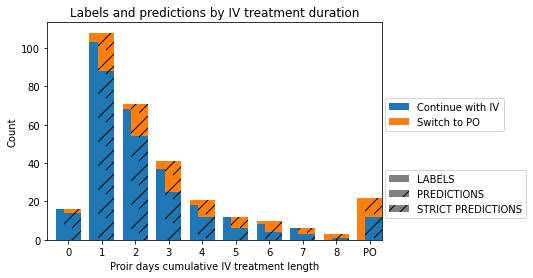

In [114]:
plot_clustered_stacked([df1, df2, df3],["LABELS", "PREDICTIONS", "STRICT PREDICTIONS"], title="Labels and predictions by IV treatment duration",  H="/")

<AxesSubplot:title={'center':'eICU labels and predictions by IV treatment duration'}, xlabel='Proir days cumulative IV treatment length', ylabel='Count'>

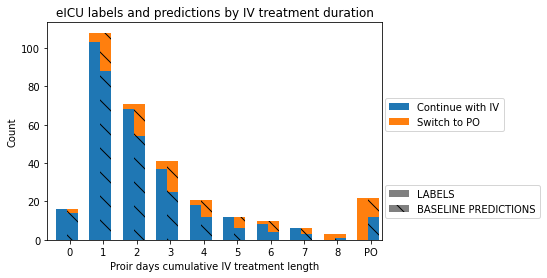

In [80]:
plot_clustered_stacked([df1, df2],["LABELS", "BASELINE PREDICTIONS"], title="eICU labels and predictions by IV treatment duration",  H="\\")